# SBI for the parameters of a line fit

## 1 Import all the things

In [3]:
## first, import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [4]:
import sbi
# from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi import analysis as analysis
from sbi.inference.base import infer
import torch

In [5]:
# this is necessary to import modules from this repo
import sys
sys.path.append('..')
from src.scripts import models, utils, train

## 2 Define and test out the simulator
Like any good SBI code, you should start with the simulator. Here, each invocation of the simulator will produce a set of noisy points along a line. In other words, each invocation is defined by a noise width, m, and b.

In [6]:
def simulator(thetas):#, percent_errors):
    # just plop the pendulum within here
    m, b, sigma = thetas
    x = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    ε = rs.normal(loc=0, scale=sigma, size = len(x)) 
    return m * x + b + ε

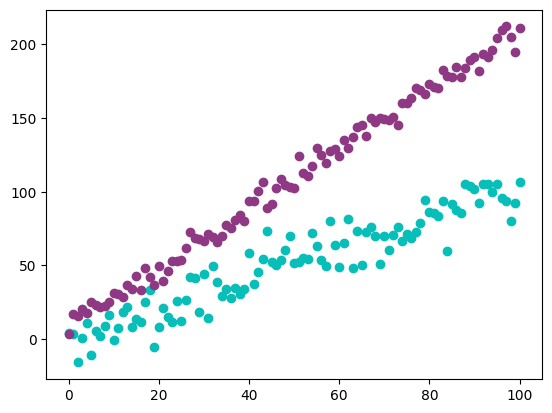

In [7]:
plt.scatter(np.linspace(0, 100, 101),
            simulator([1, 1, 10]), color = '#07BEB8')
plt.scatter(np.linspace(0, 100, 101),
            simulator([2, 9, 5]), color = '#8F3985')
plt.show()

## 3 Generate data
Each data "point" is a set of points corresponding to a slope and intercept. The potential future hierarchical aspect of this is inferring things about the distribution of lines in the universe.

The effective data length is 1000 x 100 (because there are 100 x points per each data point).

In [16]:
length_df = 1000
xs = np.zeros((length_df, 3))
ys = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.normal(loc=1, scale=1)
    b = rs.normal(loc=0, scale=10)
    sigma = abs(rs.normal(loc=0, scale=10))
    thetas = [m, b, sigma]
    xs[r,:] = thetas
    ys.append(simulator(thetas))

In [17]:
print(np.shape(xs), np.shape(ys))

(1000, 3) (1000, 101)


## Define the prior
And then visualize them.

In [18]:
num_dim = 3

low_bounds = torch.tensor([0, -10, 0])
high_bounds = torch.tensor([10, 10, 10])

prior = sbi.utils.BoxUniform(low = low_bounds, high = high_bounds)

<Figure size 640x480 with 0 Axes>

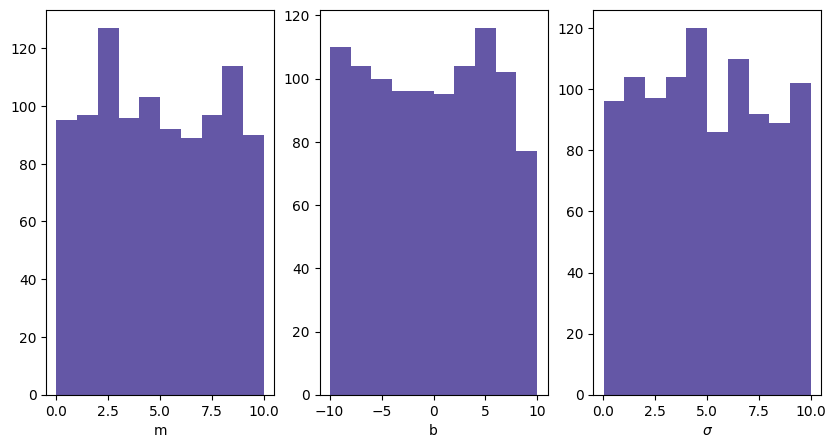

In [19]:
m_sample = []
b_sample = []
sig_sample = []

for i in range(1000):
  samp = prior.sample()
  m_sample.append(np.array(samp[0]))
  b_sample.append(np.array(samp[1]))
  sig_sample.append(np.array(samp[2]))

plt.clf()
fig = plt.figure(figsize = (10,5))
ax0 = fig.add_subplot(131)
ax0.hist(m_sample, color = '#6457A6')
ax0.set_xlabel('m')
ax1 = fig.add_subplot(132)
ax1.hist(b_sample, color = '#6457A6')
ax1.set_xlabel('b')
ax2 = fig.add_subplot(133)
ax2.hist(sig_sample, color = '#6457A6')
ax2.set_xlabel('$\sigma$')
plt.show()

## Run the SBI
Normalizing flow; neural network magic.

In [50]:
posterior = infer(simulator, prior, "SNPE", num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 173 epochs.

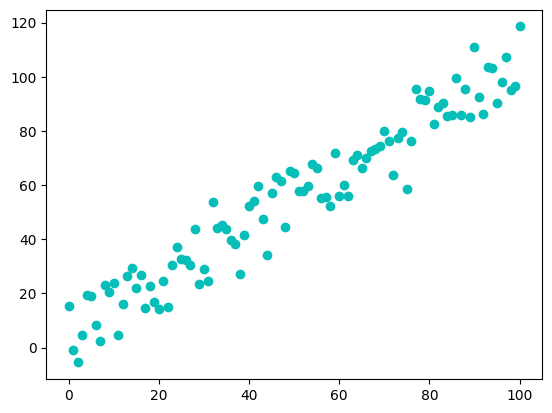

In [46]:
# generate a true dataset
theta_true = [1, 5,  8]
y_true = simulator(theta_true)

# and visualize it
plt.clf()
plt.scatter(np.linspace(0, 100, 101),
            y_true, color = '#07BEB8')
plt.show()



Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

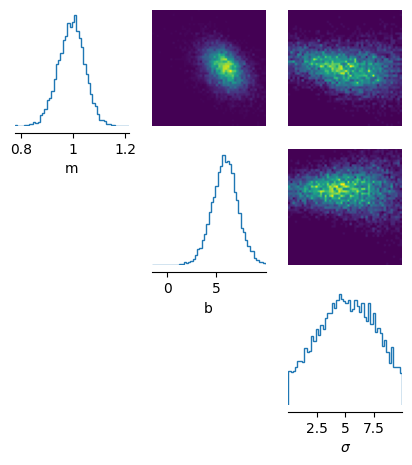

In [47]:
# sample from the posterior
posterior_samples_1 = posterior.sample((10000,), x = y_true)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples_1, 
    labels = ['m', 'b', '$\sigma$'],
    #limits = [[0,10],[-10,10],[0,10]],
    truths = theta_true,
    figsize=(5, 5)
)

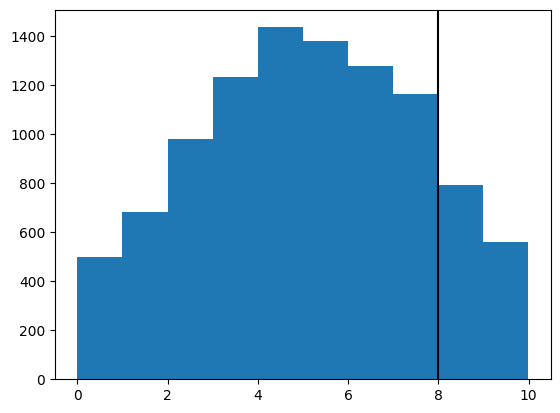

In [48]:
plt.hist(posterior_samples_1[:,2])
plt.axvline(x = theta_true[2], color = 'black')
plt.show()

Now plot the true sigma value (black lines) compared to the one sigma value from the posterior distribution.

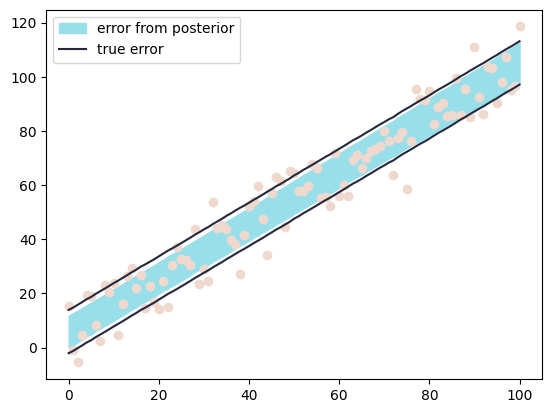

In [49]:
# also go through and plot one sigma interval
# plot the true values
plt.clf()
xs_sim = np.linspace(0, 100, 101)
ys_sim = np.zeros((np.shape(posterior_samples_1)[0], len(xs_sim)))
for j in range(np.shape(posterior_samples_1)[0]):
    ys_sim[j,:] = simulator(posterior_samples_1[j,:])

plt.fill_between(xs_sim,
                 np.mean(ys_sim, axis = 0) - 1 * np.std(ys_sim, axis = 0),
                 np.mean(ys_sim, axis = 0) + 1 * np.std(ys_sim, axis = 0),
                 color = '#98DFEA', label = 'error from posterior')
plt.plot(xs_sim, np.mean(ys_sim, axis = 0) + theta_true[2],
         color = '#25283D', label = 'true error')
plt.plot(xs_sim, np.mean(ys_sim, axis = 0) - theta_true[2],
         color = '#25283D')
plt.scatter(xs_sim,
            y_true, 
            color = '#EFD9CE')    
plt.legend()

plt.show()

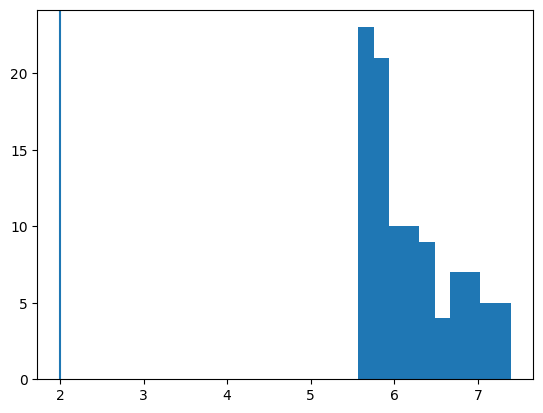

In [29]:
# Another way to look at this would be to plop it on its side and look at the sigma values at each x
plt.hist(np.std(ys_sim, axis = 0))
plt.axvline(x = theta_true[2])
plt.show()